<Response [200]>
Found 1084 files belonging to 2 classes.
0x742d35Cc6634C0532925a3b844Bc454e4438f44e will process images from index 0 to -1. Total images: 3


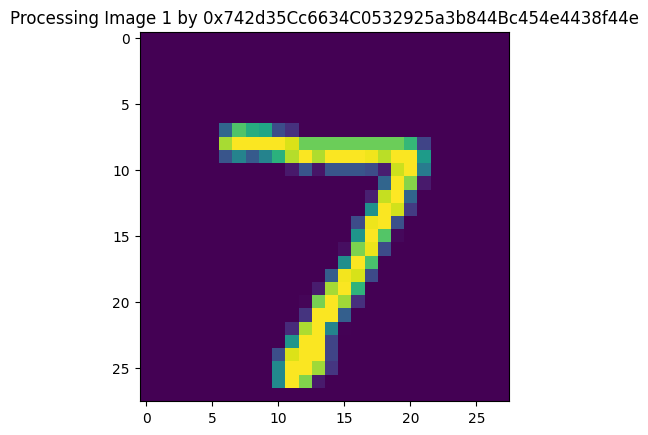

1/1 [==============================] - 0s 190ms/step


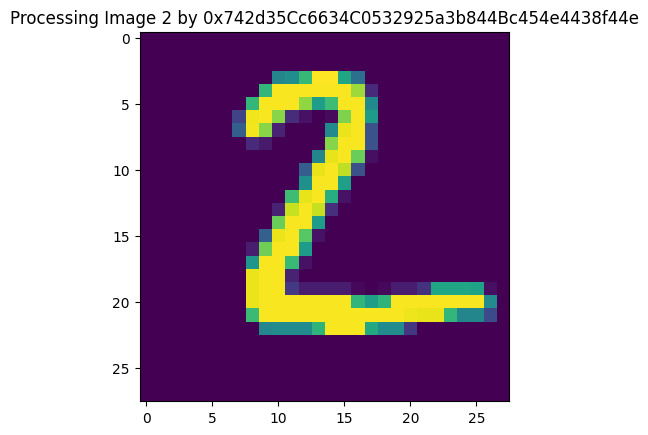

1/1 [==============================] - 0s 31ms/step


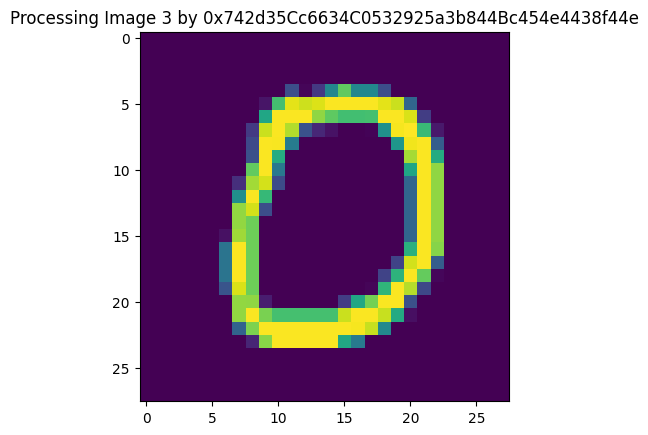

1/1 [==============================] - 0s 34ms/step
Total number of processed images by 0x742d35Cc6634C0532925a3b844Bc454e4438f44e: 3
Labels received for 0x742d35Cc6634C0532925a3b844Bc454e4438f44e: [7, 2, 2]
Labels successfully submitted to the server.


In [20]:
import os
import requests
import tensorflow as tf
from PIL import Image
import zipfile
import math
import matplotlib.pyplot as plt
import numpy as np



class client:
    def __init__(self, model_url, dataset_url):
        self.default_model_url = model_url
        self.default_dataset_url = dataset_url
        self.batches = {}
        self.received_labels = {}  # Dictionary to store labels from each user

    def request_batch(self, eth_address):
        if eth_address not in self.batches:
            self.batches[eth_address] = {
                'model_url': self.default_model_url,
                'dataset_url': self.default_dataset_url,
            }
        # Initialize the received labels list for this user
        if eth_address not in self.received_labels:
            self.received_labels[eth_address] = []
        return self.batches[eth_address]

    def receive_labels(self, eth_address, labels, requestID):
        # Convert labels to list of native Python data types
        labels = labels.tolist() if isinstance(labels, np.ndarray) else labels
        labels = [int(label) if isinstance(label, np.integer) else label for label in labels]

        # Ensure requestID is a native int
        requestID = int(requestID)

        self.received_labels[eth_address].extend(labels)
        print(f"Labels received for {eth_address}: {labels}")

        data = {
            "requestID": requestID,  # Now should be a native int
            "userEthAddress": eth_address,
            "labels": labels
        }

        # Making a PUT request to submit the labels to the server
        response = requests.put("https://dull-scrubs-bee.cyclic.app/labels", json=data)

        if response.status_code == 202:
            print("Labels successfully submitted to the server.")
        else:
            print("Failed to submit labels. Response:", response.text)


class user:
    def __init__(self, eth_address, client):
        self.eth_address = eth_address
        self.client = client
        self.model = None
        self.dataset = None
        self.start_index = 0
        self.end_index = 0

    # Other methods (_download_file, _extract_zip, _filter_images, getuserModel) remain unchanged...
    def _download_file(self, url, destination_path):
        if "drive.google.com" in url:
            file_id = url.split('/d/')[1].split('/')[0]
            url = f"https://drive.google.com/uc?export=download&id={file_id}"
        response = requests.get(url, stream=True)
        with open(destination_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)

    def _extract_zip(self, file_path, extract_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    def _filter_images(self, directory):
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(subdir, file)
                try:
                    Image.open(file_path)
                except (IOError, SyntaxError):
                    #print(f'Removing non-image file: {file_path}')
                    os.remove(file_path)

    def getuserModel(self, model_url):
        model_path = 'mnist_digit_model'
        self._download_file(model_url, model_path)
        self.model = tf.keras.models.load_model(model_path)

    def getDataset(self, dataset_url):
        dataset_zip_path = 'mnist_digit_model.zip'
        dataset_extract_path = 'mnist_digit_dataset'
        self._download_file(dataset_url, dataset_zip_path)
        self._extract_zip(dataset_zip_path, dataset_extract_path)
        self._filter_images(dataset_extract_path)

        # Disable shuffling and set a fixed batch size
        self.dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_extract_path,
            color_mode='grayscale',
            image_size=(28, 28),
            batch_size=128,  # Set batch size to 100
            shuffle=False  # Disable shuffling to maintain the order
        )

    def request_and_load_batch(self):
        batch_info = self.client.request_batch(self.eth_address)
        self.getuserModel(batch_info['model_url'])
        # Call getDataset with only the necessary dataset_url
        self.getDataset(batch_info['dataset_url'])

    def startMining(self,requestID):
        if not self.model or not self.dataset:
            raise ValueError("Model or dataset not loaded")

        predictions = []
        total_images_to_process = 3

        print(f"{self.eth_address} will process images from index {self.start_index} to {self.end_index - 1}. Total images: {total_images_to_process}")

        processed_images = 0
        for images_batch, _ in self.dataset:
            for image in images_batch:
                if processed_images >= total_images_to_process:
                    break

                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f"Processing Image {processed_images + 1} by {self.eth_address}")
                plt.show()

                # Predict each image individually
                pred = self.model.predict(tf.expand_dims(image, 0))  # Add batch dimension
                prediction = tf.argmax(pred, axis=1).numpy()[0]  # Get the prediction for the single image
                predictions.append(prediction)
                processed_images += 1

            if processed_images >= total_images_to_process:
                break

        #self.client.receive_labels(self.eth_address, predictions,requestID)
        print(f"Total number of processed images by {self.eth_address}: {len(predictions)}")
        return predictions



# Define the Ethereum address
address = "0x742d35Cc6634C0532925a3b844Bc454e4438f44e"

# Making a GET request to the FastAPI server to receive the batch information
response = requests.get("https://dull-scrubs-bee.cyclic.app/batch", params={"address": address})
batch_data = response.json()

# Printing the batch data

# Parsing the JSON response to extract the necessary information
model_url = batch_data["modelUrl"]
dataset_url = batch_data["datasetUrl"]
requestID = batch_data["requestID"]

print(response)

# Initializing the client class with the data received from the server
client = client(model_url, dataset_url)

# Create a single user and assign them a batch
single_user = user(address, client)
single_user.request_and_load_batch()
labels = single_user.startMining(requestID)
client.receive_labels(address, labels,requestID)



